### Dataset Loading and testing

In [483]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
from sklearn.model_selection import train_test_split

#now load this dataset 
h5f = h5py.File('./datasets/s8_sio2tio2_v2.h5','r')
X = h5f['sizes'][:]
Y = h5f['spectrum'][:]

#get the ranges of the loaded data
num_layers = X.shape[1]
num_lpoints = Y.shape[1]
size_max = np.amax(X)
size_min = np.amin(X)
size_av = 0.5*(size_max + size_min)

#this information is not given in the dataset
lam_min = 300
lam_max = 1200
lams = np.linspace(lam_min, lam_max, num_lpoints)

#create a train - test split of the dataset
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.4, random_state=42)

# normalize inputs 
x_train = (x_train - 50)/20 
x_test = (x_test - 50)/20 

print("Dataset has been loaded")
print("x-train", x_train.shape)
print("x-test ", x_test.shape)
print("y-train", y_train.shape)
print("y-test ", y_test.shape)


Dataset has been loaded
x-train (60000, 8)
x-test  (40000, 8)
y-train (60000, 256)
y-test  (40000, 256)


### Model Development

In [477]:
from keras import backend as K
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Reshape, UpSampling1D, Conv1D, Flatten, Activation
from keras.utils import np_utils, multi_gpu_model
from keras.regularizers import l2
from keras.wrappers.scikit_learn import KerasRegressor
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization



from sklearn.model_selection import cross_val_score, KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_gpus = 2
gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]



#define various models here
#naive percentage loss
def size_percent_loss(y_true, y_pred):
    y_true_a = 0.5*y_true*(size_max - size_min) + size_av
    y_pred_a = 0.5*y_pred*(size_max - size_min) + size_av
    y_err = np.abs(y_true_a - y_pred_a)/y_true_a
    y_err_f = K.flatten(y_err)
    return K.sum(y_err_f)

#naive percentage loss
def naive_percent_loss(y_true, y_pred):
    y_err = np.abs(y_true - y_pred)/y_true
    y_err_f = K.flatten(y_err)
    return K.sum(y_err_f)


#function to test performance on testset  
def calc_mre(y_true, y_pred):
    y_err = 100*np.abs(y_true - y_pred)/y_true
    return np.mean(y_err)

#function to test performance on testset  
def calc_mre_K(y_true, y_pred):
    y_err = 100*np.abs(y_true - y_pred)/y_true
    return K.mean(y_err)



def naiveploss_mgpu_model():
    # create model
    model = Sequential()
    model = multi_gpu_model(model, gpus=num_gpus)
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='first' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='second' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='third' ))
    model.add(Dense(250, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='fourth' ))
    model.add(Dense(250, kernel_initializer='normal', name='last'))
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', context = gpu_list)
    return model

def naiveploss_model():
    # create model
    model = Sequential()
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='first' ))
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='second' ))
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='third' ))
    model.add(Dense(256, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu', 
                    name='fourth' ))
    model.add(Dense(256, kernel_initializer='normal', name='last'))
    # Compile model
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=['accuracy'])
    return model

import timeit
#here we must have a function that calls the training routine n times and then gives avg and stddev 
# of the resulting figures
def net_performance(modelfunc, num_trials=3, batch_size=32, num_epochs=200, num_gpus=2):
    models = []
    train_err = np.ones(num_trials)
    test_err = np.ones(num_trials)
    val_err = np.ones(num_trials)
    train_time = np.ones(num_trials)
    for tnum in np.arange(num_trials):
        print("iteration: " + str(tnum + 1))
        model_curr = modelfunc()
        x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
        start_time = timeit.default_timer()
        history = model_curr.fit(x_t, y_t,
                    batch_size=batch_size*num_gpus,
                    epochs=num_epochs, 
                    verbose=1,
                    validation_data=(x_v, y_v))
        train_time[tnum] = timeit.default_timer() - start_time
        models.append(model_curr)
        train_err[tnum] =  (100.0/num_lpoints)*history.history['loss'][-1]/(batch_size*num_gpus)
        val_err[tnum] =   (100.0/num_lpoints)*history.history['val_loss'][-1]/(batch_size*num_gpus)
        test_err[tnum] = calc_mre(y_test, models[tnum].predict(x_test))
    return train_err, val_err, test_err, train_time

#staging area for new models 
def plot_training_history(history, factor):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    loss = np.asarray(loss)/(factor)
    val_loss = np.asarray(val_loss)/(factor)
    epochs = len(loss)
    
    fig, axs = plt.subplots(1,1, figsize=(5,5))
    axs.semilogy(np.arange(1, epochs + 1), loss, label='train error')
    axs.semilogy(np.arange(1, epochs + 1), val_loss, label='validation error')
    axs.set_xlabel('Epoch number')
    axs.set_ylabel('Mean Relative Error (MRE) (%)')
    axs.legend(loc="best")


def conv1d_model_bnorm():
    
    #gpu_list = ["gpu(%d)" % i for i in range(num_gpus)]
    
    # create model
    model = Sequential()
    
    model.add(Dense(256, input_dim=8, kernel_initializer='normal', 
                    name='first' ))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    
    model.add(Reshape((4, 64)))
    model.add(UpSampling1D(size=2))
    
    model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, kernel_initializer='normal'))
    #model.add(BatchNormalization())
    model.add(Activation('relu'))
    #model.add(Dropout(0.2))
    #model.add(UpSampling1D(size=5))

    model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, kernel_initializer='normal'))
    model.add(Activation('relu'))
    #model.add(Dropout(0.3))
    
#     model.add(Conv1D(filters=64, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))   
#     model.add(Dropout(0.3))

#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))   
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))  
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))  
    
#     model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
#                      dilation_rate=1, kernel_initializer='normal'))
#     model.add(Activation('relu'))  
    
    model.add(Conv1D(filters=32, kernel_size=3, strides=1, padding='same', 
                     dilation_rate=1, kernel_initializer='normal'))
    model.add(Activation('relu'))    
    
    
    
    model.add(Flatten())
    # Compile model
#     if num_gpus == 1:
    model.compile(loss=naive_percent_loss, optimizer='adam', metrics=[calc_mre_K])
#     else:
#         model.compile(loss=naive_percent_loss, optimizer='adam', metrics=['accuracy'], context = gpu_list)
    
    
    return model    

### Model testing

In [ ]:

model = conv1d_model_bnorm()
#model = conv1d_model(1)

#model = naiveploss_model()
model.summary()

    
# from IPython.display import SVG
# from keras.utils.vis_utils import model_to_dot

# #SVG(model_to_dot(model).create(prog='dot', format='svg'))
 
    
x_t, x_v, y_t, y_v = train_test_split(x_train, y_train, test_size=0.2, random_state=42)
# model = naiveploss_mgpu_model()
# model.summary()   
history = model.fit(x_t, y_t,
                    batch_size=64,
                    epochs=500, 
                    verbose=1,
                    validation_data=(x_v, y_v))







y_pred = model.predict(x_test)
print(calc_mre(y_test, y_pred))



/home/hegder/anaconda3/envs/deep/lib/python3.6/site-packages/keras/backend/mxnet_backend.py:89: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use this API`keras.utils.to_channels_first(x_input)`to transform `channels_last` data to `channels_first` format and also please change the `image_data_format` in `keras.json` to `channels_first`.Note: `x_input` is a Numpy tensor or a list of Numpy tensorRefer to: https://github.com/awslabs/keras-apache-mxnet/tree/master/docs/mxnet_backend/performance_guide.md
  train_symbol = func(*args, **kwargs)
/home/hegder/anaconda3/envs/deep/lib/python3.6/site-packages/keras/backend/mxnet_backend.py:92: UserWarning: MXNet Backend performs best with `channels_first` format. Using `channels_last` will significantly reduce performance due to the Transpose operations. For performance improvement, please use th

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
first (Dense)                (None, 256)               2304      
_________________________________________________________________
activation_364 (Activation)  (None, 256)               0         
_________________________________________________________________
reshape_101 (Reshape)        (None, 4, 64)             0         
_________________________________________________________________
up_sampling1d_133 (UpSamplin (None, 8, 64)             0         
_________________________________________________________________
conv1d_279 (Conv1D)          (None, 8, 64)             12352     
_________________________________________________________________
activation_365 (Activation)  (None, 8, 64)             0         
_________________________________________________________________
conv1d_280 (Conv1D)          (None, 8, 32)             6176      
__________

/home/hegder/anaconda3/envs/deep/lib/python3.6/site-packages/mxnet/module/bucketing_module.py:408: UserWarning: Optimizer created manually outside Module but rescale_grad is not normalized to 1.0/batch_size/num_workers (1.0 vs. 0.015625). Is this intended?
  force_init=force_init)


48000/48000 [==============================] - 2s 45us/step - loss: 2323.6912 - calc_mre_K: 14.1827 - val_loss: 896.4662 - val_calc_mre_K: 5.4789
Epoch 2/500
48000/48000 [==============================] - 2s 43us/step - loss: 742.7378 - calc_mre_K: 4.5333 - val_loss: 579.9123 - val_calc_mre_K: 3.5441
Epoch 3/500
48000/48000 [==============================] - 2s 43us/step - loss: 509.3823 - calc_mre_K: 3.1090 - val_loss: 444.2056 - val_calc_mre_K: 2.7147
Epoch 4/500
48000/48000 [==============================] - 2s 40us/step - loss: 418.0988 - calc_mre_K: 2.5519 - val_loss: 407.5913 - val_calc_mre_K: 2.4910
Epoch 5/500
48000/48000 [==============================] - 2s 40us/step - loss: 387.3467 - calc_mre_K: 2.3642 - val_loss: 376.1371 - val_calc_mre_K: 2.2988
Epoch 6/500
48000/48000 [==============================] - 2s 40us/step - loss: 370.4068 - calc_mre_K: 2.2608 - val_loss: 350.7615 - val_calc_mre_K: 2.1437
Epoch 7/500
48000/48000 [==============================] - 2s 42us/step - 

48000/48000 [==============================] - 2s 42us/step - loss: 216.5780 - calc_mre_K: 1.3219 - val_loss: 218.1752 - val_calc_mre_K: 1.3334
Epoch 54/500
48000/48000 [==============================] - 2s 44us/step - loss: 210.8565 - calc_mre_K: 1.2870 - val_loss: 250.5887 - val_calc_mre_K: 1.5315
Epoch 55/500
48000/48000 [==============================] - 2s 41us/step - loss: 209.3812 - calc_mre_K: 1.2780 - val_loss: 257.2145 - val_calc_mre_K: 1.5721
Epoch 56/500
48000/48000 [==============================] - 2s 43us/step - loss: 212.8660 - calc_mre_K: 1.2992 - val_loss: 193.8064 - val_calc_mre_K: 1.1845
Epoch 57/500
48000/48000 [==============================] - 2s 40us/step - loss: 207.9597 - calc_mre_K: 1.2693 - val_loss: 200.2478 - val_calc_mre_K: 1.2238
Epoch 58/500
48000/48000 [==============================] - 2s 43us/step - loss: 208.2500 - calc_mre_K: 1.2711 - val_loss: 195.3068 - val_calc_mre_K: 1.1937
Epoch 59/500
48000/48000 [==============================] - 2s 44us/ste

48000/48000 [==============================] - 2s 43us/step - loss: 176.5676 - calc_mre_K: 1.0777 - val_loss: 179.6574 - val_calc_mre_K: 1.0980
Epoch 106/500
48000/48000 [==============================] - 2s 43us/step - loss: 172.0308 - calc_mre_K: 1.0500 - val_loss: 173.6216 - val_calc_mre_K: 1.0611
Epoch 107/500
48000/48000 [==============================] - 2s 44us/step - loss: 173.2844 - calc_mre_K: 1.0576 - val_loss: 194.6735 - val_calc_mre_K: 1.1898
Epoch 108/500
48000/48000 [==============================] - 2s 41us/step - loss: 171.0071 - calc_mre_K: 1.0437 - val_loss: 161.3094 - val_calc_mre_K: 0.9859
Epoch 109/500
48000/48000 [==============================] - 2s 43us/step - loss: 170.7646 - calc_mre_K: 1.0423 - val_loss: 163.2023 - val_calc_mre_K: 0.9975
Epoch 110/500
48000/48000 [==============================] - 2s 41us/step - loss: 173.6916 - calc_mre_K: 1.0601 - val_loss: 163.8243 - val_calc_mre_K: 1.0013
Epoch 111/500
48000/48000 [==============================] - 2s 41

Epoch 157/500
48000/48000 [==============================] - 2s 40us/step - loss: 155.3898 - calc_mre_K: 0.9484 - val_loss: 184.5836 - val_calc_mre_K: 1.1281
Epoch 158/500
48000/48000 [==============================] - 2s 39us/step - loss: 157.5874 - calc_mre_K: 0.9618 - val_loss: 167.1605 - val_calc_mre_K: 1.0216
Epoch 159/500
48000/48000 [==============================] - 2s 42us/step - loss: 155.5386 - calc_mre_K: 0.9493 - val_loss: 152.6168 - val_calc_mre_K: 0.9328
Epoch 160/500
48000/48000 [==============================] - 2s 41us/step - loss: 157.0394 - calc_mre_K: 0.9585 - val_loss: 204.3699 - val_calc_mre_K: 1.2490
Epoch 161/500
48000/48000 [==============================] - 2s 42us/step - loss: 157.2073 - calc_mre_K: 0.9595 - val_loss: 150.0930 - val_calc_mre_K: 0.9173
Epoch 162/500
48000/48000 [==============================] - 2s 42us/step - loss: 154.8789 - calc_mre_K: 0.9453 - val_loss: 154.3105 - val_calc_mre_K: 0.9431
Epoch 163/500
48000/48000 [=========================

Epoch 209/500
48000/48000 [==============================] - 2s 48us/step - loss: 146.3837 - calc_mre_K: 0.8935 - val_loss: 142.2346 - val_calc_mre_K: 0.8693
Epoch 210/500
48000/48000 [==============================] - 2s 49us/step - loss: 146.4737 - calc_mre_K: 0.8940 - val_loss: 142.9147 - val_calc_mre_K: 0.8735
Epoch 211/500
48000/48000 [==============================] - 2s 48us/step - loss: 145.3539 - calc_mre_K: 0.8872 - val_loss: 149.6881 - val_calc_mre_K: 0.9149
Epoch 212/500
48000/48000 [==============================] - 2s 48us/step - loss: 148.5170 - calc_mre_K: 0.9065 - val_loss: 150.0849 - val_calc_mre_K: 0.9173
Epoch 213/500
48000/48000 [==============================] - 2s 47us/step - loss: 144.6560 - calc_mre_K: 0.8829 - val_loss: 140.1282 - val_calc_mre_K: 0.8564
Epoch 214/500
48000/48000 [==============================] - 2s 47us/step - loss: 148.1572 - calc_mre_K: 0.9043 - val_loss: 144.9958 - val_calc_mre_K: 0.8862
Epoch 215/500
48000/48000 [=========================

Epoch 261/500
48000/48000 [==============================] - 2s 49us/step - loss: 141.3701 - calc_mre_K: 0.8629 - val_loss: 144.6493 - val_calc_mre_K: 0.8841
Epoch 262/500
48000/48000 [==============================] - 2s 49us/step - loss: 139.7921 - calc_mre_K: 0.8532 - val_loss: 132.5857 - val_calc_mre_K: 0.8103
Epoch 263/500
48000/48000 [==============================] - 2s 50us/step - loss: 141.5622 - calc_mre_K: 0.8640 - val_loss: 136.2479 - val_calc_mre_K: 0.8327
Epoch 264/500
48000/48000 [==============================] - 2s 49us/step - loss: 137.8996 - calc_mre_K: 0.8417 - val_loss: 134.3789 - val_calc_mre_K: 0.8213
Epoch 265/500
48000/48000 [==============================] - 2s 49us/step - loss: 140.5640 - calc_mre_K: 0.8579 - val_loss: 140.5279 - val_calc_mre_K: 0.8589
Epoch 266/500
48000/48000 [==============================] - 2s 49us/step - loss: 138.8792 - calc_mre_K: 0.8477 - val_loss: 146.6169 - val_calc_mre_K: 0.8961
Epoch 267/500
48000/48000 [=========================

2.212953421799862


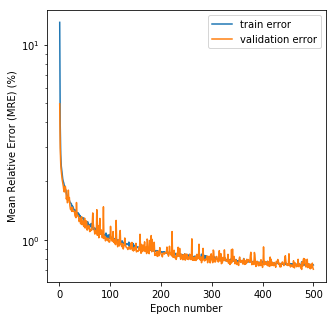

In [482]:
y_pred = model.predict(x_test)
print(calc_mre(y_test, y_pred))
history60 = history
plot_training_history(history, 64*2.56)

[52 49 44 70 50 48 33 60]


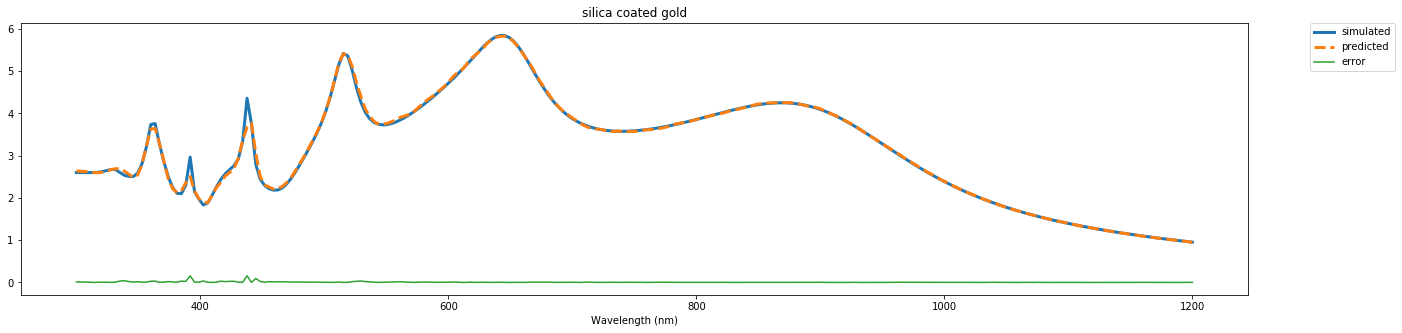

In [410]:
import snlay as snlay
#here we test edge cases where failure happens
#size = np.array([70, 60, 50, 40, 30, 20, 10, 10])
#size = np.array([70, 70, 70, 70, 70, 70, 70, 70])
#size = np.array([30, 30, 30, 30, 30, 30, 30, 30])

#size = np.array([65, 65, 65, 65, 55, 65, 35, 65])
#size = np.array([68, 30, 38, 60, 63, 60, 68, 68])

size = np.random.randint(30, 71, 8)
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
spec_ac = snlay.calc_spectrum(size, mats, lams)

print(size)


size = (size - 50.0)/20.0


spec = model.predict(np.expand_dims(size, axis = 0))

#spec = model.predict(size)
# print(spec.shape)
spec = np.ravel(spec)


fig1 = plt.figure(figsize=(22,5))
ax = fig1.add_subplot(1,1,1)
ax.set_title('silica coated gold')
ax.set_xlabel('Wavelength (nm)')
plt.plot(lams, spec_ac, linewidth=3, label='simulated')
plt.plot(lams, spec, '--', linewidth=3, label='predicted')
plt.plot(lams, np.abs(spec_ac - spec)/spec_ac, label='error')

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)



### Model Benchmarking

In [ ]:
#Here is where we in-depth model evaluation and benchmarking

#model = naiveploss_model()
train_e, val_e, test_e, train_t = net_performance(naiveploss_model, 5, 64, 500, 1)

print("Training duration")
print(np.mean(train_t), np.std(train_t))

print("Training error")
print(np.mean(train_e), np.std(train_e))

print("Validation error")
print(np.mean(val_e), np.std(val_e))

print("Testing error")
print(train_e)
print(np.mean(train_e), np.std(train_e))





\\7]=/ we record the timing and resource consumption 
'
- naiveploss,  

  Total params: 253,250,  
  training size: 48,000    val size 12,000    test size: 40,000 
  
 1 gpu case, 500 epochs, 64 batch size. 
 Training duration
970.6306939371977 162.52772916709793
Training error
0.28162434966405236 0.004849006439278184
Validation error
0.28847073678970336 0.01748113934849215
Testing error
[0.28093684 0.29020114 0.28278018 0.27629951 0.27790407]
0.28162434966405236 0.004849006439278184
   
 
 2 gpu case, 500 epochs, 64 batch size. 
  Training duration
1415.9011616169942 72.01714343631177
Training error
0.14291583093007407 0.0017661558666610126
Validation error
0.14036797358194988 0.005636169118478038
Testing error
[0.14436209 0.14525352 0.14023539 0.14201304 0.14271513]
0.14291583093007407 0.0017661558666610126
  
  


### Inverse scattering 

In [ ]:


model_d = Sequential()
model_d.add(Dense(8, input_dim=1, kernel_initializer='normal', activation='linear', 
                    name='dummy', use_bias=False))

for layer in model.layers:
    model_d.add(layer)

for layer in model_d.layers[1:]:
    layer.trainable = False

for ind in range(1,len(model_d.layers)):
    model_d.layers[ind].set_weights(model.layers[ind-1].get_weights())

model_d.compile(loss=naive_percent_loss, optimizer='adam')    
    
    
#model_d.summary()


# # let us create a target spectrum first
import snlay as snlay
#size = np.array([60, 65, 65, 65, 35, 35, 35, 35])
size = np.random.randint(30,70,8)
mats = np.array([3, 4, 3, 4, 3, 4, 3, 4])
target = snlay.calc_spectrum(size, mats, lams)

print(size)

# #do the training here
xd_t = np.ones((1,1))
yd_t = target.reshape(1,250)





history = model_d.fit(xd_t, yd_t,
                    batch_size=1,
                    epochs=5000, 
                    verbose=0)

# #here is the final result
size_out = model_d.get_layer('dummy')
wts = size_out.get_weights()
wts = np.array(wts).ravel()
size_res= 0.5*wts*(size_max - size_min) + size_av
size_res_rounded = np.round(size_res)

spec_zer = model_d.predict(xd_t).ravel()
achieved = snlay.calc_spectrum(size_res_rounded, mats, lams)


fig1 = plt.figure(figsize=(22,5))
ax = fig1.add_subplot(1,1,1)
#plt.plot(lams, spec_zer, label='new model')
plt.plot(lams, target, linewidth=2, label='target')
plt.plot(lams, achieved, '--', linewidth=3, label='achieved')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

print(size_res_rounded)


### Model shipment

In [ ]:

    
from keras.models import load_model

#Creates a HDF5 file 'my_model.h5'
model.save('my_model.h5')

# Deletes the existing model
#del model  

# Returns a compiled model identical to the previous one
#model = load_model('my_model.h5')

